# Линейная регрессия: переобучение и регуляризация

В этом задании мы на примерах увидим, как переобучаются линейные модели, разберем, почему так происходит, и выясним, как диагностировать и контролировать переобучение.

Во всех ячейках, где написан комментарий с инструкциями, нужно написать код, выполняющий эти инструкции. Остальные ячейки с кодом (без комментариев) нужно просто выполнить. Кроме того, в задании требуется отвечать на вопросы; ответы нужно вписывать после выделенного слова "__Ответ:__".

Напоминаем, что посмотреть справку любого метода или функции (узнать, какие у нее аргументы и что она делает) можно с помощью комбинации Shift+Tab. Нажатие Tab после имени объекта и точки позволяет посмотреть, какие методы и переменные есть у этого объекта.

In [188]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

Мы будем работать с датасетом __"bikes_rent.csv"__, в котором по дням записаны календарная информация и погодные условия, характеризующие автоматизированные пункты проката велосипедов, а также число прокатов в этот день. Последнее мы будем предсказывать; таким образом, мы будем решать задачу регрессии.

### Знакомство с данными

Загрузите датасет с помощью функции __pandas.read_csv__ в переменную __df__. Выведите первые 5 строчек, чтобы убедиться в корректном считывании данных:

In [189]:
df = pd.read_csv('bikes_rent.csv')
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600


Для каждого дня проката известны следующие признаки (как они были указаны в источнике данных):
* _season_: 1 - весна, 2 - лето, 3 - осень, 4 - зима
* _yr_: 0 - 2011, 1 - 2012
* _mnth_: от 1 до 12
* _holiday_: 0 - нет праздника, 1 - есть праздник
* _weekday_: от 0 до 6
* _workingday_: 0 - нерабочий день, 1 - рабочий день
* _weathersit_: оценка благоприятности погоды от 1 (чистый, ясный день) до 4 (ливень, туман)
* _temp_: температура в Цельсиях
* _atemp_: температура по ощущениям в Цельсиях
* _hum_: влажность
* _windspeed(mph)_: скорость ветра в милях в час
* _windspeed(ms)_: скорость ветра в метрах в секунду
* _cnt_: количество арендованных велосипедов (это целевой признак, его мы будем предсказывать)

Итак, у нас есть вещественные, бинарные и номинальные (порядковые) признаки, и со всеми из них можно работать как с вещественными. С номинальныеми признаками тоже можно работать как с вещественными, потому что на них задан порядок. Давайте посмотрим на графиках, как целевой признак зависит от остальных

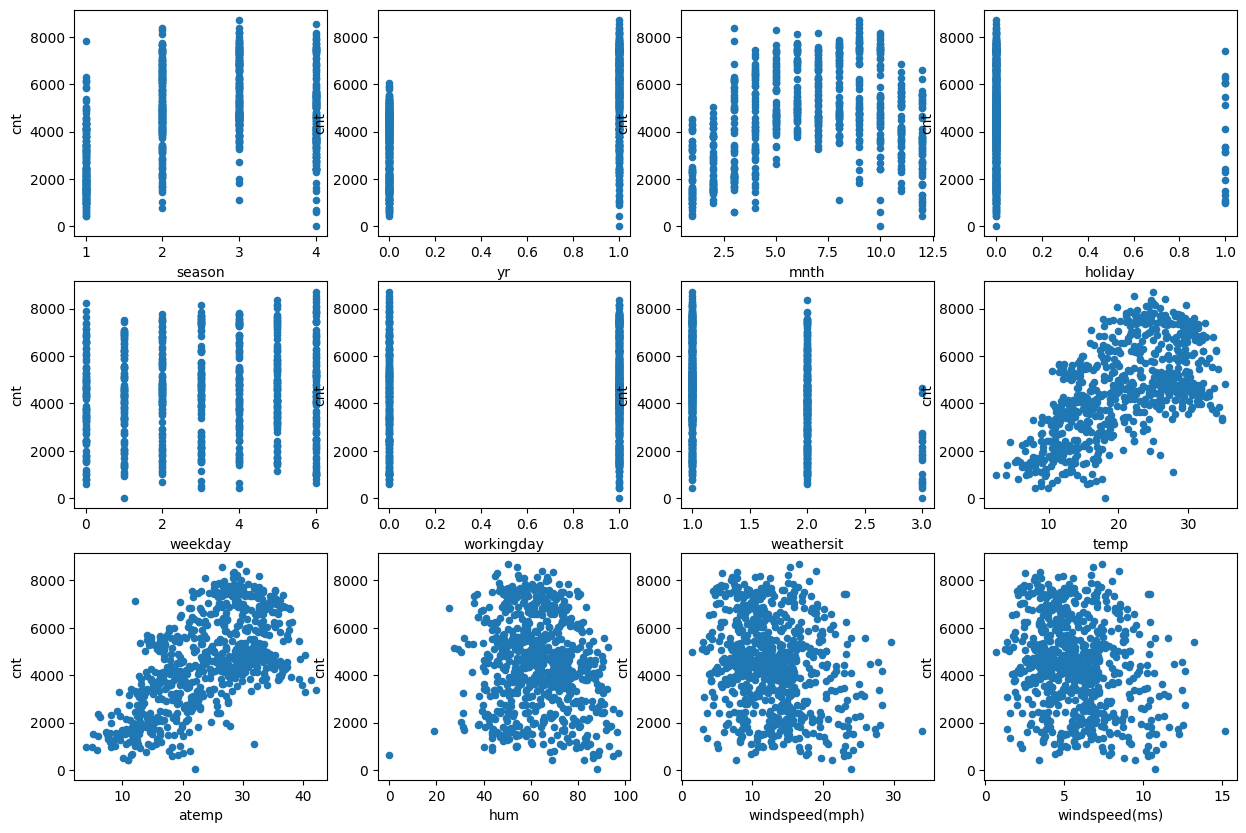

In [190]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))
for idx, feature in enumerate(df.columns[:-1]):
    df.plot(feature, "cnt", subplots=True, kind="scatter", ax=axes[idx // 4, idx % 4])

#### 1. [0.5 балла] Укажите один или два признака, от которых число прокатов скорее всего зависит линейно. Каким способом можно более строго оценить уровень линейной зависимости между признаками и целевой переменной? Сделайте это.
   * ответ:  Я думаю, что число прокатов линейно зависят от atemp (температура по ощущениям). Чтобы строго оценить уровень линейной зависимости я думаю, стоит построить матрицу корреляций.
   
   

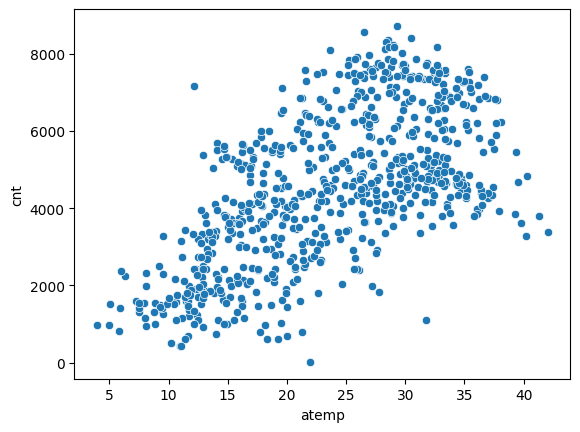

In [191]:
sns.scatterplot(data = df, x = 'atemp', y = 'cnt'); # видно по графику, что признаки коррелируют
#  подтвердим это построив матрицу корреляций 

В выборке есть признаки, коррелирующие с целевым, а значит, задачу можно решать линейными методами.

По графикам видно, что некоторые признаки похожи друг на друга. Поэтому давайте также посчитаем корреляции между вещественными признаками.

#### 2. [0.5 балла] Посчитайте попарные корреляции между вещественными признаками.

In [192]:
# у нас получается вещественными признаками являются df[temp:] (все начиная с temp)
df_2 = df[['temp', 'atemp', 'hum',	'windspeed(mph)', 'windspeed(ms)', 'cnt']]

In [193]:
df_2.corr()

,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
temp,1.000000,0.991702,0.126963,-0.157944,-0.157944,0.627494
atemp,0.991702,1.000000,0.139988,-0.183643,-0.183643,0.631066
hum,0.126963,0.139988,1.000000,-0.248489,-0.248489,-0.100659
windspeed(mph),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
windspeed(ms),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
cnt,0.627494,0.631066,-0.100659,-0.234545,-0.234545,1.000000


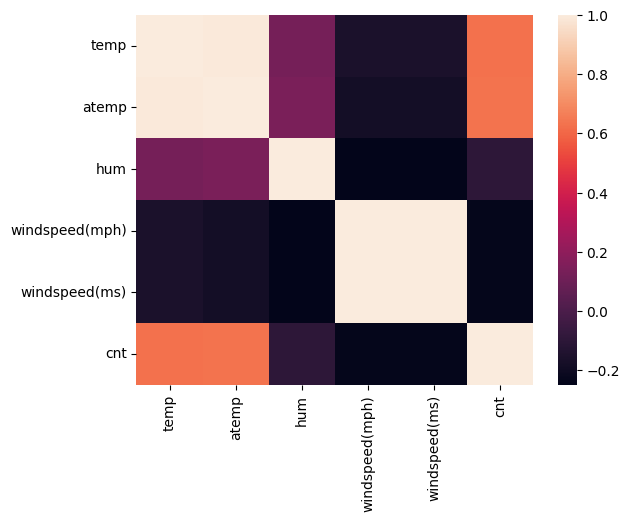

In [194]:
sns.heatmap(df_2.corr()); # как видно temp и atemp сильно коррелируют с cnt

На диагоналях, как и полагается, стоят единицы. Однако в матрице имеются еще две пары сильно коррелирующих столбцов: temp и atemp (коррелируют по своей природе) и два windspeed (потому что это просто перевод одних единиц в другие). Далее мы увидим, что этот факт негативно сказывается на обучении линейной модели.

Напоследок посмотрим средние признаков (метод mean), чтобы оценить масштаб признаков и доли 1 у бинарных признаков.

#### 3. [0.5 балла] Выведите средние значения признаков.

In [195]:
df.mean()

season               2.496580
yr                   0.500684
mnth                 6.519836
holiday              0.028728
weekday              2.997264
workingday           0.683995
weathersit           1.395349
temp                20.310776
atemp               23.717699
hum                 62.789406
windspeed(mph)      12.762576
windspeed(ms)        5.705220
cnt               4504.348837
dtype: float64

Признаки имеют разный масштаб, значит для дальнейшей работы нам лучше нормировать матрицу объекты-признаки.

### Проблема первая: коллинеарные признаки

Итак, в наших данных один признак дублирует другой, и есть еще два очень похожих. Конечно, мы могли бы сразу удалить дубликаты, но давайте посмотрим, как бы происходило обучение модели, если бы мы не заметили эту проблему. 

Для начала проведем масштабирование, или стандартизацию признаков: из каждого признака вычтем его среднее и поделим на стандартное отклонение.

Кроме того, нужно перемешать выборку, это потребуется для кросс-валидации.

#### 4. [1 балл] Выполните нормирование признаков и перемешайте данные.

In [196]:
from sklearn.preprocessing import StandardScaler
data_sc = pd.DataFrame(StandardScaler().fit_transform(df),columns=df.columns)
df = data_sc
df=df.sample(frac=1,random_state=1)
print(df)

       season        yr      mnth   holiday   weekday  workingday  weathersit  \
404 -1.348213  0.998633 -1.310268 -0.171981  0.500513    0.679706   -0.726048   
726 -1.348213  0.998633  1.588660 -0.171981  0.500513    0.679706    1.110427   
159 -0.447350 -1.001369 -0.150697 -0.171981  0.500513    0.679706    1.110427   
422 -1.348213  0.998633 -1.310268 -0.171981 -0.996930    0.679706   -0.726048   
512 -0.447350  0.998633 -0.440589 -0.171981 -1.496077   -1.471225   -0.726048   
..        ...       ...       ...       ...       ...         ...         ...   
645  1.354375  0.998633  1.008875 -0.171981 -1.496077   -1.471225    1.110427   
715  1.354375  0.998633  1.588660 -0.171981 -1.496077   -1.471225    1.110427   
72  -1.348213 -1.001369 -1.020375 -0.171981 -0.996930    0.679706   -0.726048   
235  0.453512 -1.001369  0.429089 -0.171981  0.001366    0.679706   -0.726048   
37  -1.348213 -1.001369 -1.310268 -0.171981 -0.996930    0.679706   -0.726048   

         temp     atemp    

#### 5. [1 балл] Обучите линейную регрессию на всех данных и выведите веса модели.

Веса хранятся в переменной coef_ класса регрессора.

Можно выводить пары (название признака, вес), воспользовавшись функцией zip, встроенной в язык python.

Названия признаков хранятся в переменной df.columns

In [197]:
from sklearn.linear_model import LinearRegression
x = df.drop(columns='cnt')
y = df['cnt']
reg = LinearRegression().fit(x, y)
for sups in zip(df.columns,reg.coef_):
  print(sups)

('season', 0.2948886997177725)
('yr', 0.5279074488751971)
('mnth', -0.07299189197582978)
('holiday', -0.044814072152764235)
('weekday', 0.07088523642673772)
('workingday', 0.029129696925429154)
('weathersit', -0.17058402152980526)
('temp', 0.1898211234359572)
('atemp', 0.30247562403346306)
('hum', -0.07521468477733852)
('windspeed(mph)', 6437158983.198772)
('windspeed(ms)', -6437158983.301283)


Мы видим, что веса при линейно-зависимых признаках по модулю значительно больше, чем при других признаках.

Чтобы понять, почему так произошло, вспомним аналитическую формулу, по которой вычисляются веса линейной модели в методе наименьших квадратов:

$w = (X^TX)^{-1} X^T y$.

Если в X есть коллинеарные (линейно-зависимые) столбцы, матрица $X^TX$ становится вырожденной, и формула перестает быть корректной. Чем более зависимы признаки, тем меньше определитель этой матрицы и тем хуже аппроксимация $Xw \approx y$. Такая ситуацию называют _проблемой мультиколлинеарности_, вы обсуждали ее на лекции.

С парой temp-atemp чуть менее коррелирующих переменных такого не произошло, однако на практике всегда стоит внимательно следить за коэффициентами при похожих признаках.

__Решение__ проблемы мультиколлинеарности состоит в _регуляризации_ линейной модели. К оптимизируемому функционалу прибавляют L1 или L2 норму весов, умноженную на коэффициент регуляризации $\alpha$. В первом случае метод называется Lasso, а во втором --- Ridge. Подробнее об этом также рассказано в лекции.

Обучите регрессоры Ridge и Lasso с параметрами по умолчанию и убедитесь, что проблема с весами решилась.

In [198]:
from sklearn.linear_model import Lasso, Ridge
clf = Ridge(alpha=1.0)
clf.fit(x,y)
for sups in zip(clf.coef_,df.columns):
  print(sups)

(0.2908562720202425, 'season')
(0.5263473168803133, 'yr')
(-0.06812039720930074, 'mnth')
(-0.04480950839230603, 'holiday')
(0.07128783115698442, 'weekday')
(0.02887727461345197, 'workingday')
(-0.17167839223649564, 'weathersit')
(0.19962843780705905, 'temp')
(0.29255186508846215, 'atemp')
(-0.07493795119511608, 'hum')
(-0.05127339281957919, 'windspeed(mph)')
(-0.05127339285704419, 'windspeed(ms)')


In [199]:
clf_2 = Lasso(alpha=0.1)
clf_2.fit(x,y)
for sups in zip(clf_2.coef_,df.columns):
  print(sups)

(0.15666114089754793, 'season')
(0.44036870748445334, 'yr')
(0.0, 'mnth')
(-0.0, 'holiday')
(0.0, 'weekday')
(0.0, 'workingday')
(-0.12505907607320524, 'weathersit')
(0.07076884534287192, 'temp')
(0.3699328268459848, 'atemp')
(-0.0, 'hum')
(-0.009404172171458185, 'windspeed(mph)')
(-1.4286885703972393e-11, 'windspeed(ms)')


#### 6. [0.5 балла] Обучите линейную регрессию с L1-регуляризацией на всех данных и выведите веса модели.

In [200]:
from sklearn.linear_model import Lasso, Ridge
clf = Ridge(alpha=1.0)
clf.fit(x,y)
clf.coef_

array([ 0.29085627,  0.52634732, -0.0681204 , -0.04480951,  0.07128783,
        0.02887727, -0.17167839,  0.19962844,  0.29255187, -0.07493795,
       -0.05127339, -0.05127339])

#### 7. [0.5 балла] Обучите линейную регрессию с L2-регуляризацией на всех данных и выведите веса модели.

In [201]:
clf_2 = Lasso(alpha=0.1)
clf_2.fit(x,y)
clf_2.coef_

array([ 1.56661141e-01,  4.40368707e-01,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -1.25059076e-01,  7.07688453e-02,
        3.69932827e-01, -0.00000000e+00, -9.40417217e-03, -1.42868857e-11])

### Проблема вторая: неинформативные признаки

В отличие от L2-регуляризации, L1 обнуляет веса при некоторых признаках. Объяснение данному факта было (или будет?) в лекциях, 

Давайте пронаблюдаем, как меняются веса при увеличении коэффициента регуляризации $\alpha$ (в лекции коэффициент при регуляризаторе мог быть обозначен другой буквой).

In [202]:
alphas = np.arange(1, 500, 50)
coefs_lasso = np.zeros((alphas.shape[0], x.shape[1])) # матрица весов размера (число регрессоров) x (число признаков)
coefs_ridge = np.zeros((alphas.shape[0], x.shape[1]))


In [203]:
coefs_lasso

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

#### 8. [1 балл] Для каждого значения коэффициента из alphas обучите регрессор Lasso и запишите веса в соответствующую строку матрицы coefs_lasso, а затем обучите Ridge и запишите веса в coefs_ridge.


In [204]:
enuma=enumerate(alphas)
for i, a in enuma:
    lasso_reg = Lasso(alpha=a).fit(x, y)
    ridge_reg = Ridge(alpha=a).fit(x, y)
    coefs_lasso[i,:] = lasso_reg.coef_
    coefs_ridge[i,:] = ridge_reg.coef_

Визуализируем динамику весов при увеличении параметра регуляризации:

Text(0.5, 1.0, 'Ridge')

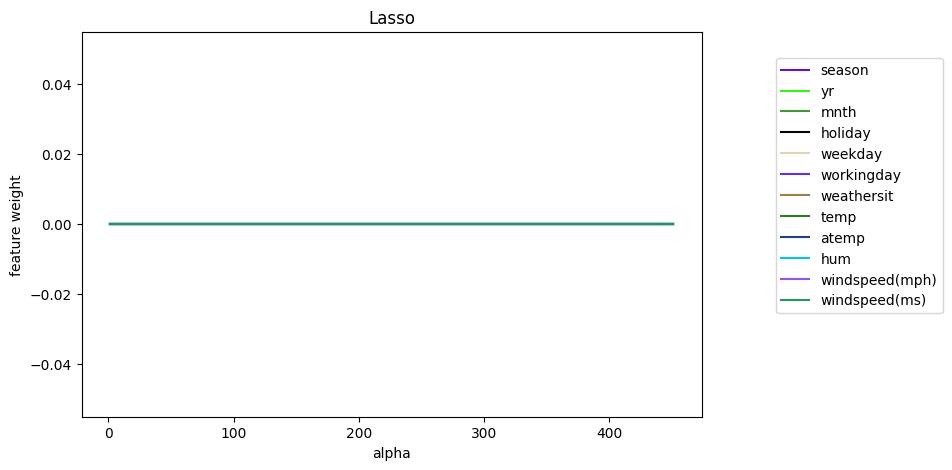

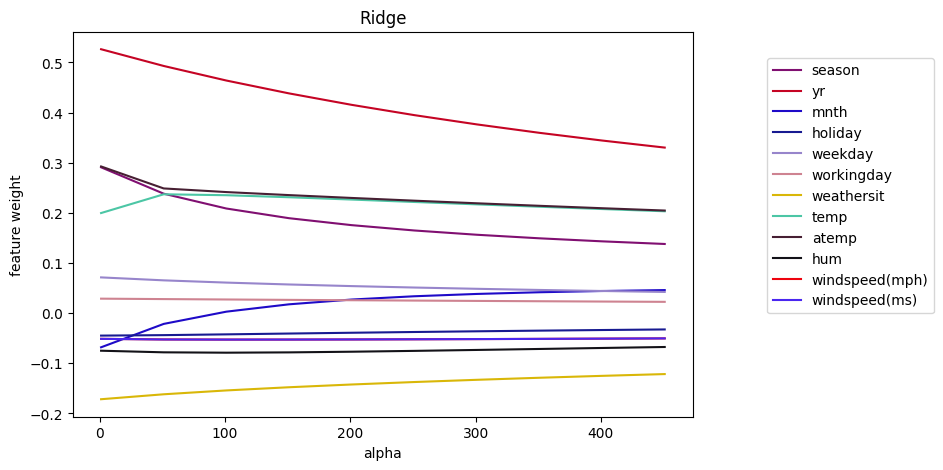

In [205]:
plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

#### 9. [1 балл] Ответьте на следующие вопросы, глядя на графики или выводя коэффициенты на печать.

Ответьте на вопросы (каждый 0.25 балла):
1. Какой регуляризатор (Ridge или Lasso) агрессивнее уменьшает веса при одном и том же alpha?
    * Ответ:
1. Что произойдет с весами Lasso, если alpha сделать очень большим? Поясните, почему так происходит.
    * Ответ: 
1. Можно ли утверждать, что Lasso исключает один из признаков windspeed при любом значении alpha > 0? А Ridge? Ситается, что регуляризатор исключает признак, если коэффициент при нем < 1e-3.
    * Ответ:   
1. Какой из регуляризаторов подойдет для отбора неинформативных признаков?
    * Ответ:

Далее будем работать с Lasso.

Итак, мы видим, что при изменении alpha модель по-разному подбирает коэффициенты признаков. Нам нужно выбрать наилучшее alpha. 

Для этого, во-первых, нам нужна метрика качества. Будем использовать в качестве метрики сам оптимизируемый функционал метода наименьших квадратов, то есть Mean Square Error.

Во-вторых, нужно понять, на каких данных эту метрику считать. Нельзя выбирать alpha по значению MSE на обучающей выборке, потому что тогда мы не сможем оценить, как модель будет делать предсказания на новых для нее данных. Если мы выберем одно разбиение выборки на обучающую и тестовую (это называется holdout), то настроимся на конкретные "новые" данные, и вновь можем переобучиться. Поэтому будем делать несколько разбиений выборки, на каждом пробовать разные значения alpha, а затем усреднять MSE. Удобнее всего делать такие разбиения кросс-валидацией, то есть разделить выборку на K частей, или блоков, и каждый раз брать одну из них как тестовую, а из оставшихся блоков составлять обучающую выборку. 

Делать кросс-валидацию для регрессии в sklearn совсем просто: для этого есть специальный регрессор, __LassoCV__, который берет на вход список из alpha и для каждого из них вычисляет MSE на кросс-валидации. После обучения (если оставить параметр cv=3 по умолчанию) регрессор будет содержать переменную __mse\_path\___, матрицу размера len(alpha) x k, k = 3 (число блоков в кросс-валидации), содержащую значения MSE на тесте для соответствующих запусков. Кроме того, в переменной alpha\_ будет храниться выбранное значение параметра регуляризации, а в coef\_, традиционно, обученные веса, соответствующие этому alpha_.

Обратите внимание, что регрессор может менять порядок, в котором он проходит по alphas; для сопоставления с матрицей MSE лучше использовать переменную регрессора alphas_.

In [206]:
from sklearn.linear_model import LassoCV

#### 10. [2 балла] Обучите регрессор LassoCV на всех параметрах регуляризации из alpha. Постройте график _усредненного_ по строкам MSE в зависимости от alpha. Выберите лучший alpha с точки зрения _усредненного_ MSE.


Пояснение:

На каждом разбиении оптимальное значение alpha свое, и ему соответствует большое MSE на других разбиениях. Получается, что мы настраиваемся на конкретные обучающие и контрольные выборки. При выборе alpha на кросс-валидации мы выбираем нечто "среднее", что будет давать приемлемое значение метрики на разных разбиениях выборки. 

In [207]:
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LassoCV
alphas = np.arange(1, 100, 5)
cv = RepeatedKFold(n_splits= 10 , n_repeats= 3 , random_state= 1 )

model = LassoCV(alphas= alphas, cv=cv, n_jobs=-1)
model.fit(x, y)
print(model.alpha_) #=6
las = Lasso(alpha=6)
las.fit(x,y)
for el in zip(df.columns,las.coef_):
  print(el)


96
('season', 0.0)
('yr', 0.0)
('mnth', 0.0)
('holiday', -0.0)
('weekday', 0.0)
('workingday', 0.0)
('weathersit', -0.0)
('temp', 0.0)
('atemp', 0.0)
('hum', -0.0)
('windspeed(mph)', -0.0)
('windspeed(ms)', -0.0)


Наконец, как принято в анализе данных, давайте проинтерпретируем результат.
Для ответов на вопросы используйте Lasso модель с лучшим alpha, найденным в прошлом пункте.

#### 11. [1.5 балла] Ответьте на вопросы, каждый 0.5 балла
1. В последней обученной модели выберите 4 признака с наибольшими (положительными) коэффициентами (и выпишите их), посмотрите на визуализации зависимостей cnt от этих признаков, которые мы рисовали в блоке "Знакомство с данными". Видна ли возрастающая линейная зависимость cnt от этих признаков по графикам? Логично ли утверждать (из здравого смысла), что чем больше значение этих признаков, тем больше людей захотят взять велосипеды? 
    * Ответ:
1. Выберите 3 признака с наибольшими по модулю отрицательными коэффициентами (и выпишите их), посмотрите на соответствующие визуализации. Видна ли убывающая линейная зависимость? Логично ли утверждать, что чем больше величина этих признаков, тем меньше людей захотят взять велосипеды?
    * Ответ:
1. Выпишите признаки с коэффициентами, близкими к нулю (< 1e-3). Как вы думаете, почему модель исключила их из модели (вновь посмотрите на графики)? Верно ли, что они никак не влияют на спрос на велосипеды?
    * Ответ:

### Заключение

![burn](./display.jpeg)

Итак, мы посмотрели, как можно следить за адекватностью линейной модели, как отбирать признаки и как грамотно, по возможности не настраиваясь на какую-то конкретную порцию данных, подбирать коэффициент регуляризации. 

Стоит отметить, что с помощью кросс-валидации удобно подбирать лишь небольшое число параметров (1, 2, максимум 3), потому что для каждой допустимой их комбинации нам приходится несколько раз обучать модель, а это времязатратный процесс, особенно если нужно обучаться на больших объемах данных.

## Дополнительные баллы:
### 12. [0.5 балла]: все графики выполнены аккуратно и подписаны
### 13. [0.5 балла]: прикрепите свой любимый анекдот, баллы получат несколько лучших
*Итого*: максимум 11/10